### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/timing_runs/washington/2023_07_14_09_29_01/count_data

deaths.csv                       risk_exposure_time.hdf
deaths.hdf                       sbp_medication_person_time.csv
healthcare_visits.csv            sbp_medication_person_time.hdf
healthcare_visits.hdf            state_person_time.csv
intervention_person_time.csv     state_person_time.hdf
intervention_person_time.hdf     transition_count.csv
ldlc_medication_person_time.csv  transition_count.hdf
ldlc_medication_person_time.hdf  ylds.csv
polypill_person_time.csv         ylds.hdf
polypill_person_time.hdf         ylls.csv
risk_exposure_time.csv           ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/timing_runs/washington/2023_07_14_09_29_01/count_data/'

### Exploring Data

In [4]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
deaths.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,age,value
0,0,Female,2023,acute_ischemic_stroke,deaths,29,baseline,25_to_29,1
1,1,Female,2023,acute_ischemic_stroke,deaths,29,lifestyle_100,25_to_29,1
2,2,Female,2023,acute_ischemic_stroke,deaths,29,outreach_100,25_to_29,1
3,3,Female,2023,acute_ischemic_stroke,deaths,29,polypill_100,25_to_29,1
4,4,Female,2023,acute_ischemic_stroke,deaths,29,baseline,30_to_34,0


In [5]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
person_time.value.sum()

85899050.91854894

### Total DALYs by Year

In [6]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv')
yll = yll.rename(columns = {'value':'yll'})
yll_total = yll.groupby(['sex', 'age', 'input_draw', 'year']).yll.sum().reset_index()
yld = pd.read_csv(sim_results_dir + 'ylds.csv')
yld = yld.rename(columns = {'value':'yld'})
yld_total = yld.groupby(['sex', 'age', 'input_draw', 'year']).yld.sum().reset_index()
daly_total = pd.concat([yll_total, yld_total.yld], axis=1)
daly_total['daly'] = daly_total['yll'] + daly_total['yld'] 

daly_total.head()

,sex,age,input_draw,year,yll,yld,daly
0,Female,25_to_29,29,2023,1734.525176,31.231978,1765.757153
1,Female,25_to_29,29,2024,729.018317,38.683772,767.702089
2,Female,25_to_29,29,2025,1704.410795,43.102241,1747.513035
3,Female,25_to_29,29,2026,256.280208,42.107150,298.387358
4,Female,25_to_29,29,2027,969.805468,48.396434,1018.201902


In [7]:
daly_sum = (daly_total
                .groupby(['year'])
                .daly.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum.head()

,year,mean,2.5%,97.5%
0,2023,3286.712210,450.169212,8628.946053
1,2024,3415.294921,469.595768,8936.589425
2,2025,3386.924671,426.035171,9429.455961
3,2026,3473.034918,461.657686,9674.872665
4,2027,3472.709778,311.463345,8978.299393


### All Cause Mortality Graphs

In [8]:
result_summary = (deaths
                      .groupby(['age', 'sex', 'year'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.4750,0.0,4.000
1,25_to_29,Female,2024,0.5125,0.0,3.000
2,25_to_29,Female,2025,0.4000,0.0,2.050
3,25_to_29,Female,2026,0.4625,0.0,3.025
4,25_to_29,Female,2027,0.4125,0.0,3.000


#### All Cause Mortality Graph with Rate

In [9]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year', 'input_draw']).ptvalue.sum().reset_index()

per_time_group.head()

,age,sex,year,input_draw,ptvalue
0,25_to_29,Female,2023,29,26782.182067
1,25_to_29,Female,2023,232,26708.281999
2,25_to_29,Female,2023,357,13252.030116
3,25_to_29,Female,2023,394,26814.992471
4,25_to_29,Female,2023,602,19781.913758


In [10]:
results_rate = deaths.groupby(['age', 'sex', 'year', 'input_draw']).value.sum().reset_index()
results_rate = pd.concat([results_rate, per_time_group.ptvalue], axis=1)
results_rate['mean_rate'] = results_rate['value'] / results_rate['ptvalue']
result_summary = (results_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000782,0.000034,0.001982
1,25_to_29,Female,2024,0.000886,0.000301,0.002518
2,25_to_29,Female,2025,0.000658,0.000046,0.001473
3,25_to_29,Female,2026,0.000805,0.000191,0.001808
4,25_to_29,Female,2027,0.000719,0.000047,0.001495


### Cause Specific Mortality Graphs
#### Acute Stroke

In [11]:
deaths_cause = (deaths
               .groupby(['age', 'sex', 'year', 'cause'])
               .value.describe(percentiles=[.025, .975])
               .filter(['mean', '2.5%', '97.5%'])
               .reset_index())

acute = deaths_cause.loc[(deaths_cause['cause'] == 'acute_ischemic_stroke')].reset_index()

acute.head()

,index,age,sex,year,cause,mean,2.5%,97.5%
0,0,25_to_29,Female,2023,acute_ischemic_stroke,0.1,0.0,1.0
1,8,25_to_29,Female,2024,acute_ischemic_stroke,0.0,0.0,0.0
2,16,25_to_29,Female,2025,acute_ischemic_stroke,0.0,0.0,0.0
3,24,25_to_29,Female,2026,acute_ischemic_stroke,0.1,0.0,1.0
4,32,25_to_29,Female,2027,acute_ischemic_stroke,0.1,0.0,1.0


In [12]:
death_rate_cause = deaths.groupby(['age', 'sex', 'year', 'input_draw', 'cause']).value.sum().reset_index()
acute_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_ischemic_stroke')].reset_index()
acute_rate.head()

,index,age,sex,year,input_draw,cause,value
0,0,25_to_29,Female,2023,29,acute_ischemic_stroke,4
1,8,25_to_29,Female,2023,232,acute_ischemic_stroke,0
2,16,25_to_29,Female,2023,357,acute_ischemic_stroke,0
3,24,25_to_29,Female,2023,394,acute_ischemic_stroke,0
4,32,25_to_29,Female,2023,602,acute_ischemic_stroke,0


In [13]:
acute_rate_2 = pd.concat([acute_rate, per_time_group.ptvalue], axis=1)
acute_rate_2['mean_rate'] = acute_rate_2['value'] / acute_rate_2['ptvalue']

acute_rate_summary = (acute_rate_2
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000015,0.0,0.000116
1,25_to_29,Female,2024,0.000000,0.0,0.000000
2,25_to_29,Female,2025,0.000000,0.0,0.000000
3,25_to_29,Female,2026,0.000021,0.0,0.000161
4,25_to_29,Female,2027,0.000016,0.0,0.000123


#### Chronic Stroke

In [14]:
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate = pd.concat([chronic_rate, per_time_group.ptvalue], axis=1)
chronic_rate['mean_rate'] = chronic_rate['value'] / chronic_rate['ptvalue']
chronic_rate_summ = (chronic_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

chronic_rate_summ

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000000,0.0,0.000000
1,25_to_29,Female,2024,0.000000,0.0,0.000000
2,25_to_29,Female,2025,0.000000,0.0,0.000000
3,25_to_29,Female,2026,0.000000,0.0,0.000000
...,...,...,...,...,...,...
536,95_plus,Male,2037,0.005734,0.0,0.012357
537,95_plus,Male,2038,0.004716,0.0,0.013664
538,95_plus,Male,2039,0.006087,0.0,0.012923
539,95_plus,Male,2040,0.003535,0.0,0.010385


#### Acute Myocardial Infarction - includes both heart failure and no heart failure

In [15]:
acute_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction') | (death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure')].reset_index()
acute_MI_rate = acute_MI_rate.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
acute_MI_rate['mean_rate'] = acute_MI_rate['value'] / acute_MI_rate['ptvalue']
acute_MI_rate_summ = (acute_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_MI_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000125,0.0,0.000920
1,25_to_29,Female,2024,0.000080,0.0,0.000477
2,25_to_29,Female,2025,0.000066,0.0,0.000481
3,25_to_29,Female,2026,0.000094,0.0,0.000764
4,25_to_29,Female,2027,0.000072,0.0,0.000495


#### Post Myocaridal Infarction

In [16]:
post_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_rate = pd.concat([post_MI_rate, per_time_group.ptvalue], axis=1)
post_MI_rate['mean_rate'] = post_MI_rate['value'] / post_MI_rate['ptvalue']
post_MI_rate_summ = (post_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000100,0.0,0.000508
1,25_to_29,Female,2024,0.000160,0.0,0.000785
2,25_to_29,Female,2025,0.000104,0.0,0.000294
3,25_to_29,Female,2026,0.000080,0.0,0.000384
4,25_to_29,Female,2027,0.000138,0.0,0.000409


#### Heart Failure

In [17]:
HF_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual')].reset_index()
HF_rate = HF_rate.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
HF_rate['mean_rate'] = HF_rate['value'] / HF_rate['ptvalue']
HF_rate_summ = (HF_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000141,0.0,0.000597
1,25_to_29,Female,2024,0.000207,0.0,0.000620
2,25_to_29,Female,2025,0.000148,0.0,0.000707
3,25_to_29,Female,2026,0.000165,0.0,0.000639
4,25_to_29,Female,2027,0.000192,0.0,0.000787


### Excess Mortality rate

#### Post Myocardial Infarction

In [18]:
per_time_state = state_person_time.groupby(['age', 'sex', 'year', 'state', 'input_draw']).value.sum().reset_index()
per_time_state = per_time_state.rename(columns = {'value':'ptvalue'})
per_time_post_MI = per_time_state.loc[(per_time_state['state'] == 'post_myocardial_infarction')].reset_index()

post_MI_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_emr = pd.concat([post_MI_emr, per_time_post_MI.ptvalue], axis=1)
post_MI_emr['mean_rate'] = post_MI_emr['value'] / post_MI_emr['ptvalue']
post_MI_emr_summ = (post_MI_emr
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_emr_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.032849,0.0,0.155603
1,25_to_29,Female,2024,0.033677,0.0,0.142121
2,25_to_29,Female,2025,0.034787,0.0,0.091026
3,25_to_29,Female,2026,0.018178,0.0,0.079798
4,25_to_29,Female,2027,0.089630,0.0,0.610462


#### Heart Failure EMR

In [19]:
death_rate_cause.cause.unique()

array(['acute_ischemic_stroke', 'acute_myocardial_infarction',
       'acute_myocardial_infarction_and_heart_failure',
       'chronic_ischemic_stroke',
       'heart_failure_from_ischemic_heart_disease',
       'heart_failure_residual', 'other_causes',
       'post_myocardial_infarction'], dtype=object)

In [20]:
per_time_HF = per_time_state.loc[(per_time_state['state'] == 'heart_failure_from_ischemic_heart_disease') | (per_time_state['state'] == 'heart_failure_residual')].reset_index()
HF_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual')].reset_index()
HF_emr = HF_emr.merge(per_time_HF[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
HF_emr['mean_rate'] = HF_emr['value'] / HF_emr['ptvalue']
HF_emr_summ = (HF_emr
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_emr_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,inf,0.0,inf
1,25_to_29,Female,2024,inf,0.0,NaN
2,25_to_29,Female,2025,1.112668,0.0,6.828055
3,25_to_29,Female,2026,inf,0.0,NaN
4,25_to_29,Female,2027,inf,0.0,inf


### Prevalence 

#### Chronic + Acute Stroke

In [21]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'acute_ischemic_stroke')].reset_index()
prev_acute = prev_acute.rename(columns = {'ptvalue':'value'})
prev_acute_rate = pd.concat([prev_acute, per_time_group.ptvalue], axis=1)
prev_acute_rate['rate']= prev_acute_rate['value'] / prev_acute_rate['ptvalue']
prev_acute_rate_sum = (prev_acute_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

prev_acute_rate_sum.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000019,0.0,0.000085
1,25_to_29,Female,2024,0.000020,0.0,0.000102
2,25_to_29,Female,2025,0.000019,0.0,0.000102
3,25_to_29,Female,2026,0.000026,0.0,0.000151
4,25_to_29,Female,2027,0.000032,0.0,0.000136


In [22]:
prev_chronic = per_time_state.loc[(per_time_state['state'] == 'chronic_ischemic_stroke')].reset_index()
prev_chronic = prev_chronic.rename(columns = {'ptvalue':'value'})
prev_chronic_rate = pd.concat([prev_chronic, per_time_group.ptvalue], axis=1)
prev_chronic_rate['rate']= prev_chronic_rate['value'] / prev_chronic_rate['ptvalue']
prev_chronic_rate_sum = (prev_chronic_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

#### Myocardial Infarction

In [23]:
prev_acute_MI = per_time_state.loc[(per_time_state['state'] == 'acute_myocardial_infarction_and_heart_failure') | ((per_time_state['state'] == 'acute_myocardial_infarction'))].reset_index()
prev_acute_MI = prev_acute_MI.rename(columns = {'ptvalue':'value'})
prev_acute_MI = prev_acute_MI.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
prev_acute_MI = prev_acute_MI.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_acute_MI['rate']= prev_acute_MI['value'] / prev_acute_MI['ptvalue']
prev_acute_MI_summ = (prev_acute_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000110,0.0,0.000392
1,25_to_29,Female,2024,0.000112,0.0,0.000472
2,25_to_29,Female,2025,0.000099,0.0,0.000337
3,25_to_29,Female,2026,0.000092,0.0,0.000320
4,25_to_29,Female,2027,0.000073,0.0,0.000293


In [24]:
prev_post_MI = per_time_state.loc[(per_time_state['state'] == 'post_myocardial_infarction')].reset_index()
prev_post_MI = prev_post_MI.rename(columns = {'ptvalue':'value'})
prev_post_MI = pd.concat([prev_post_MI, per_time_group.ptvalue], axis=1)
prev_post_MI['rate']= prev_post_MI['value'] / prev_post_MI['ptvalue']
prev_post_MI_summ = (prev_post_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.002748,0.000749,0.009201
1,25_to_29,Female,2024,0.003187,0.000853,0.011306
2,25_to_29,Female,2025,0.003617,0.000509,0.012966
3,25_to_29,Female,2026,0.003883,0.000412,0.014347
4,25_to_29,Female,2027,0.004005,0.000418,0.014779


In [25]:
tran = pd.read_csv(sim_results_dir + '/transition_count.csv')
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_myocardial_infarction_and_heart_failure", "acute_myocardial_infarction", "heart_failure_from_ischemic_heart_disease", "heart_failure_residual", "post_myocardial_infarction", "susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_post_hf = person_time.loc[(person_time['state'].isin(['post_myocardial_infarction']))].reset_index()
tran_rate_post_to_hf = tran.loc[(tran['transition'].isin(['post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_post_to_hf = tran_rate_post_to_hf.groupby(groupby_cols).sum() / per_time_sus_post_hf.groupby(groupby_cols).sum()
tran_rate_post_to_hf_summ = (tran_rate_post_to_hf.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_post_to_hf_summ#.head()

mean      2.5%     97.5%
age      sex    year                              
25_to_29 Female 2023  0.000000  0.000000  0.000000
                2024  0.000000  0.000000  0.000000
                2025  0.000000  0.000000  0.000000
                2026  0.000000  0.000000  0.000000
...                        ...       ...       ...
95_plus  Male   2037  0.111448  0.000000  0.276112
                2038  0.138201  0.000000  0.277191
                2039  0.209512  0.109706  0.347566
                2040  0.146679  0.008735  0.299452

[540 rows x 3 columns]

In [26]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_myocardial_infarction_and_heart_failure", "acute_myocardial_infarction", "heart_failure_from_ischemic_heart_disease", "heart_failure_residual", "post_myocardial_infarction", "susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_ami_post = person_time.loc[(person_time['state'].isin(['acute_myocardial_infarction']))].reset_index()
tran_rate_ami_to_post = tran.loc[(tran['transition'].isin(['acute_myocardial_infarction_to_post_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_ami_to_post = tran_rate_ami_to_post.groupby(groupby_cols).sum() / tran_rate_ami_to_post.groupby(groupby_cols).sum()
tran_rate_ami_to_post_summ = (tran_rate_ami_to_post.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_ami_to_post_summ.head()

mean  2.5%  97.5%
age      sex    year                   
25_to_29 Female 2023   1.0   1.0    1.0
                2024   1.0   1.0    1.0
                2025   1.0   1.0    1.0
                2026   1.0   1.0    1.0
                2027   1.0   1.0    1.0

### Prevalence of Heart Failure

In [27]:
prev_HF = per_time_state.loc[(per_time_state['state'] == 'heart_failure_from_ischemic_heart_disease') | ((per_time_state['state'] == 'heart_failure_residual'))].reset_index()
prev_HF = prev_HF.rename(columns = {'ptvalue':'value'})
prev_HF = prev_HF.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF['rate']= prev_HF['value'] / prev_HF['ptvalue']
prev_HF_summ = (prev_HF
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.001251,0.0,0.003468
1,25_to_29,Female,2024,0.001282,0.0,0.003110
2,25_to_29,Female,2025,0.001221,0.0,0.003590
3,25_to_29,Female,2026,0.001259,0.0,0.004136
4,25_to_29,Female,2027,0.001142,0.0,0.003195


### Incidence of First Time Acute Ischemic Stroke

In [28]:
tran_sum = (tran
                 .groupby(['age', 'sex', 'year', 'transition'])
                 .value.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_sum_stroke = tran_sum.loc[(tran_sum['transition'] == 'susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_sum_stroke.head()

,index,age,sex,year,transition,mean,2.5%,97.5%
0,10,25_to_29,Female,2023,susceptible_to_ischemic_stroke_to_acute_ischem...,1.400,0.0,8.0
1,21,25_to_29,Female,2024,susceptible_to_ischemic_stroke_to_acute_ischem...,1.400,0.0,9.0
2,32,25_to_29,Female,2025,susceptible_to_ischemic_stroke_to_acute_ischem...,1.175,0.0,7.0
3,43,25_to_29,Female,2026,susceptible_to_ischemic_stroke_to_acute_ischem...,1.500,0.0,12.0
4,54,25_to_29,Female,2027,susceptible_to_ischemic_stroke_to_acute_ischem...,1.900,0.0,8.0


In [29]:
per_time_sus_stroke = per_time_state.loc[(per_time_state['state'] == 'susceptible_to_ischemic_stroke')].reset_index()
per_time_sus_stroke.head()

,index,age,sex,year,state,input_draw,ptvalue
0,80,25_to_29,Female,2023,susceptible_to_ischemic_stroke,29,26646.647502
1,81,25_to_29,Female,2023,susceptible_to_ischemic_stroke,232,26652.780287
2,82,25_to_29,Female,2023,susceptible_to_ischemic_stroke,357,13209.713895
3,83,25_to_29,Female,2023,susceptible_to_ischemic_stroke,394,26729.133470
4,84,25_to_29,Female,2023,susceptible_to_ischemic_stroke,602,19720.585900


In [30]:
tran_rate = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw']).value.sum().reset_index()
tran_rate = tran_rate.loc[(tran_rate['transition'] == 'susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_rate = pd.concat([tran_rate, per_time_group.ptvalue], axis=1)
tran_rate['rate']= tran_rate['value'] / tran_rate['ptvalue']
tran_rate_sum = (tran_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_sum.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.000249,0.0,0.001060
1,25_to_29,Female,2024,0.000237,0.0,0.001283
2,25_to_29,Female,2025,0.000199,0.0,0.000905
3,25_to_29,Female,2026,0.000250,0.0,0.001550
4,25_to_29,Female,2027,0.000359,0.0,0.001421


### Incidence of Acute Myocardial Infraction 

In [31]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_myocardial_infarction_and_heart_failure", "acute_myocardial_infarction", "heart_failure_from_ischemic_heart_disease", "heart_failure_residual", "post_myocardial_infarction", "susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['heart_failure_from_ischemic_heart_disease']))].reset_index()
tran_rate_MI_HF = tran.loc[(tran['transition'].isin(['heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure']))].reset_index()

In [32]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_myocardial_infarction_and_heart_failure", "acute_myocardial_infarction", "heart_failure_from_ischemic_heart_disease", "heart_failure_residual", "post_myocardial_infarction", "susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['susceptible_to_ischemic_heart_disease_and_heart_failure','post_myocardial_infarction','heart_failure_from_ischemic_heart_disease']))].reset_index()
tran_rate_MI = tran.loc[(tran['transition'].isin(['heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction_to_acute_myocardial_infarction','susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols).sum() / per_time_sus_MI.groupby(groupby_cols).sum()
tran_MI_summ = (tran_rate_MI_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_MI_summ.head()

mean  2.5%     97.5%
age      sex    year                          
25_to_29 Female 2023  0.001446   0.0  0.005286
                2024  0.001494   0.0  0.005910
                2025  0.001312   0.0  0.004697
                2026  0.001207   0.0  0.004520
                2027  0.000942   0.0  0.003902

### Incidence of Heart Failure 

In [33]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['susceptible_to_ischemic_heart_disease_and_heart_failure','post_myocardial_infarction','acute_myocardial_infarction_and_heart_failure']))].reset_index()
tran_rate_HF = tran.loc[(tran['transition'].isin(['acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_HF = tran_rate_HF.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_summ = (tran_rate_HF.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_summ.head()

mean      2.5%     97.5%
age      sex    year                              
25_to_29 Female 2023  0.000652  0.000200  0.001447
                2024  0.000701  0.000206  0.001516
                2025  0.000558  0.000035  0.001047
                2026  0.000463  0.000070  0.000990
                2027  0.000359  0.000035  0.000715

### Artifacts

In [34]:
ls /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v1-20230613/

alabama.hdf               logs/               ohio.hdf
alaska.hdf                louisiana.hdf       oklahoma.hdf
arizona.hdf               maine.hdf           oregon.hdf
arkansas.hdf              maryland.hdf        paf-calculations/
california.hdf            massachusetts.hdf   pennsylvania.hdf
colorado.hdf              michigan.hdf        rhode_island.hdf
connecticut.hdf           minnesota.hdf       south_carolina.hdf
delaware.hdf              mississippi.hdf     south_dakota.hdf
district_of_columbia.hdf  missouri.hdf        south_dakotatennessee.hdf
florida.hdf               montana.hdf         tennessee.hdf
georgia.hdf               nebraska.hdf        texas.hdf
hawaii.hdf                nevada.hdf          utah.hdf
idaho.hdf                 new_hampshire.hdf   vermont.hdf
illinois.hdf              new_jersey.hdf      virginia.hdf
indiana.hdf               new_mexico.hdf      washington.hdf
iowa.hdf                  new_york.hdf        west_virginia.hdf
kansas.hdf                

In [35]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v1-20230613/washington.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [36]:
art_pop = art.load('population.structure').reset_index()
art_pop.head()

,location,sex,age_start,age_end,year_start,year_end,value
0,Washington,Female,25.0,30.0,2019,2020,242673.835574
1,Washington,Female,30.0,35.0,2019,2020,248474.720692
2,Washington,Female,35.0,40.0,2019,2020,252944.475837
3,Washington,Female,40.0,45.0,2019,2020,226925.465543
4,Washington,Female,45.0,50.0,2019,2020,228747.503435


In [37]:
art_mort = art.load('sequela.acute_ischemic_stroke.excess_mortality_rate').reset_index()
art_mort.head()

,sex,age_start,age_end,year_start,year_end,draw_0,draw_1,draw_2,draw_3,draw_4,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,Female,25.0,30.0,2019,2020,0.20595,0.32417,0.23375,0.30350,0.15667,...,0.21502,0.21088,0.20533,0.21718,0.32937,0.21018,0.24555,0.20555,0.17590,0.14510
1,Female,30.0,35.0,2019,2020,0.19390,0.25260,0.21330,0.28810,0.14812,...,0.21413,0.22667,0.22050,0.18180,0.29823,0.16585,0.20300,0.20172,0.16950,0.14580
2,Female,35.0,40.0,2019,2020,0.19290,0.22100,0.21810,0.21550,0.21258,...,0.21677,0.25743,0.23270,0.17900,0.25527,0.19975,0.22820,0.28337,0.19730,0.25707
3,Female,40.0,45.0,2019,2020,0.17445,0.20180,0.21913,0.18588,0.22750,...,0.20685,0.26250,0.22553,0.17928,0.23200,0.20350,0.23098,0.28727,0.20165,0.27075
4,Female,45.0,50.0,2019,2020,0.13855,0.19500,0.21638,0.19923,0.19290,...,0.18435,0.24190,0.19898,0.18263,0.22840,0.17710,0.21133,0.21343,0.18255,0.18685


In [38]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['washington']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v1-20230613/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        #data = data[['draw_29','draw_232','draw_357','draw_394','draw_602','draw_629','draw_650','draw_680','draw_829','draw_949']]
        
        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        #data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

#### All Cause Mortality Rates

In [39]:
art_acmr = load_artifact_data('cause', 'all_causes', 'cause_specific_mortality_rate')
art_acmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_acmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000514,0.000383,0.000679,Washington,cause_specific_mortality_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000666,0.000502,0.000869,Washington,cause_specific_mortality_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000830,0.000628,0.001078,Washington,cause_specific_mortality_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.001277,0.000977,0.001648,Washington,cause_specific_mortality_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.001992,0.001522,0.002572,Washington,cause_specific_mortality_rate,45_to_49


In [40]:
result_summary_allyears = (results_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary_allyears.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.000733,0.000000,0.002316
1,25_to_29,Male,0.001388,0.000396,0.003011
2,30_to_34,Female,0.000752,0.000000,0.001666
3,30_to_34,Male,0.001338,0.000407,0.002430
4,35_to_39,Female,0.000876,0.000152,0.001758


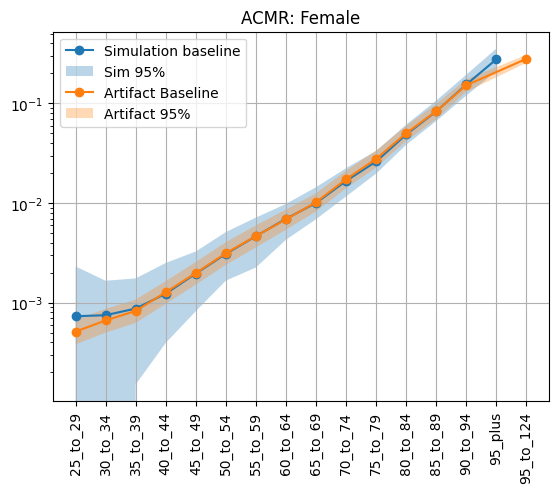

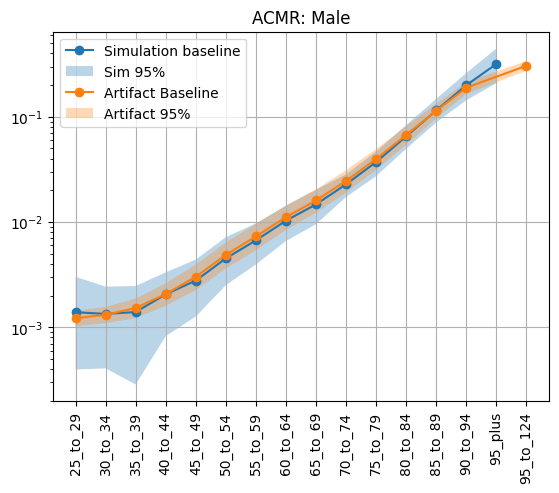

In [41]:
for sex in result_summary_allyears.sex.unique():
    plt.figure() 
    subdata = result_summary_allyears.loc[(result_summary_allyears.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_acmr.loc[(art_acmr.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'ACMR: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Cause Specific Mortality Rates

#### Stroke

In [42]:
art_csmr = load_artifact_data('cause', 'ischemic_stroke', 'cause_specific_mortality_rate') 
art_csmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_csmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,7.816925e-07,4.301786e-07,0.000001,Washington,cause_specific_mortality_rate,25_to_29
1,Female,30.0,35.0,2019,2020,1.256581e-06,7.000403e-07,0.000002,Washington,cause_specific_mortality_rate,30_to_34
2,Female,35.0,40.0,2019,2020,2.084190e-06,1.223582e-06,0.000003,Washington,cause_specific_mortality_rate,35_to_39
3,Female,40.0,45.0,2019,2020,4.072708e-06,2.621211e-06,0.000006,Washington,cause_specific_mortality_rate,40_to_44
4,Female,45.0,50.0,2019,2020,6.687930e-06,4.062284e-06,0.000010,Washington,cause_specific_mortality_rate,45_to_49


In [43]:
acute_rate_sum_allyear = (acute_rate_2
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [44]:
chronic_rate_allyear = (chronic_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [45]:
acute_rate_2 = acute_rate_2.rename(columns = {'mean_rate':'acute_rate'})
chronic_rate = chronic_rate.rename(columns = {'mean_rate':'chronic_rate'})
total_stroke_rate = pd.concat([acute_rate_2, chronic_rate.chronic_rate], axis=1)
total_stroke_rate['total_rate'] = total_stroke_rate['acute_rate'] + total_stroke_rate['chronic_rate']

In [46]:
total_stroke_rate_allyear = (total_stroke_rate
                      .groupby(['age', 'sex'])
                      .total_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
total_stroke_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.000009,0.0,0.000158
1,25_to_29,Male,0.000005,0.0,0.000074
2,30_to_34,Female,0.000003,0.0,0.000000
3,30_to_34,Male,0.000004,0.0,0.000000
4,35_to_39,Female,0.000002,0.0,0.000000


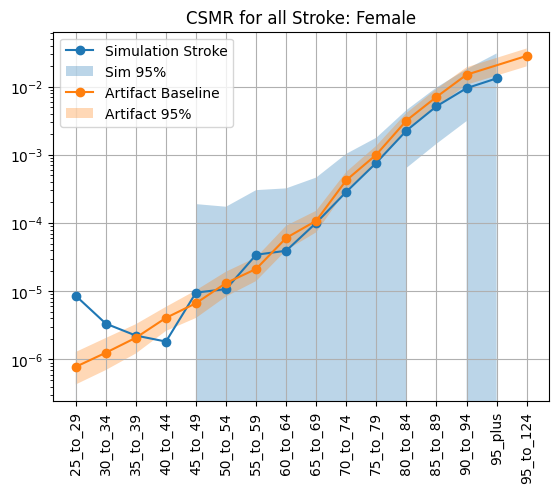

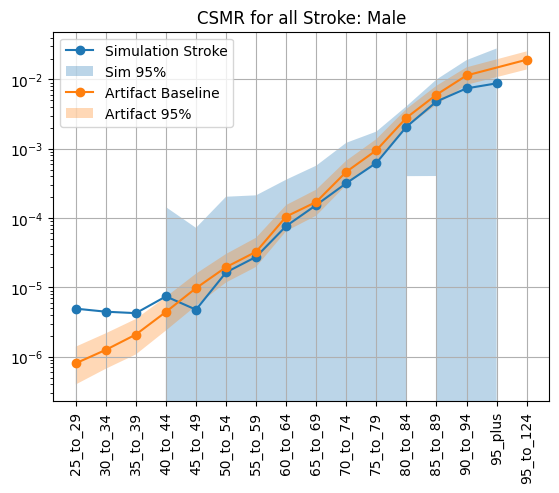

In [47]:
for sex in acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata4 = total_stroke_rate_allyear.loc[(total_stroke_rate_allyear.sex==sex)]
    plt.plot(subdata4['age'], subdata4['mean'], marker='o')
    plt.fill_between(subdata4['age'], subdata4['2.5%'], subdata4['97.5%'], alpha=.3)
    subdata3 = art_csmr.loc[(art_csmr.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'CSMR for all Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.yscale('log')
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation Stroke', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### IHD and HF Combined

In [48]:
art_csmr2 = load_artifact_data('cause', 'ischemic_heart_disease_and_heart_failure', 'cause_specific_mortality_rate') 
art_csmr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_csmr2.age_start,art_csmr2.age_end)]
art_csmr2.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000392,0.000284,0.000525,Washington,cause_specific_mortality_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000475,0.000340,0.000624,Washington,cause_specific_mortality_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000544,0.000390,0.000733,Washington,cause_specific_mortality_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000522,0.000399,0.000668,Washington,cause_specific_mortality_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.000821,0.000667,0.001001,Washington,cause_specific_mortality_rate,45_to_49


In [49]:
death_rate_cause.cause.unique()

array(['acute_ischemic_stroke', 'acute_myocardial_infarction',
       'acute_myocardial_infarction_and_heart_failure',
       'chronic_ischemic_stroke',
       'heart_failure_from_ischemic_heart_disease',
       'heart_failure_residual', 'other_causes',
       'post_myocardial_infarction'], dtype=object)

In [50]:
IHD_HF_CSMR = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction') | (death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure') | (death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual') | (death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
IHD_HF_CSMR = IHD_HF_CSMR.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
IHD_HF_CSMR = IHD_HF_CSMR.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
IHD_HF_CSMR['mean_rate'] = IHD_HF_CSMR['value'] / IHD_HF_CSMR['ptvalue']
IHD_HF_CSMR_allyear = (IHD_HF_CSMR
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
IHD_HF_CSMR_allyear

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.000626,0.000000,0.002144
1,25_to_29,Male,0.000805,0.000000,0.002035
2,30_to_34,Female,0.000602,0.000000,0.001502
3,30_to_34,Male,0.000763,0.000067,0.001804
...,...,...,...,...,...
26,90_to_94,Female,0.102640,0.073976,0.132437
27,90_to_94,Male,0.155265,0.104999,0.222344
28,95_plus,Female,0.142563,0.088834,0.197451
29,95_plus,Male,0.217231,0.115746,0.331207


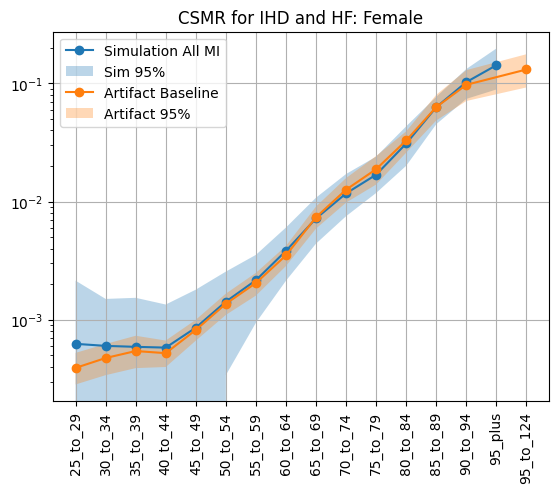

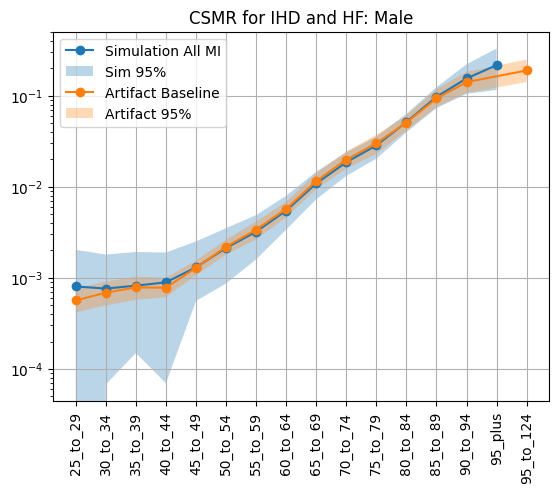

In [51]:
for sex in IHD_HF_CSMR_allyear.sex.unique():
    plt.figure() 
    subdata = IHD_HF_CSMR_allyear.loc[(IHD_HF_CSMR_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_csmr2.loc[(art_csmr2.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'CSMR for IHD and HF: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for Stroke

In [52]:
art_inc = load_artifact_data('cause', 'ischemic_stroke', 'incidence_rate')
art_inc['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc.age_start,art_inc.age_end)]
art_inc.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000101,0.000040,0.000212,Washington,incidence_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000140,0.000074,0.000247,Washington,incidence_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000196,0.000099,0.000335,Washington,incidence_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000300,0.000183,0.000454,Washington,incidence_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.000454,0.000249,0.000747,Washington,incidence_rate,45_to_49


In [53]:
tran_rate_sum_allyear = (tran_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, 0.5, .975])
                 .filter(['50%', '2.5%', '97.5%'])
                 .reset_index())
tran_rate_sum_allyear.head()

,age,sex,year,50%,2.5%,97.5%
0,25_to_29,Female,2023,0.000000,0.0,0.001060
1,25_to_29,Female,2024,0.000000,0.0,0.001283
2,25_to_29,Female,2025,0.000076,0.0,0.000905
3,25_to_29,Female,2026,0.000000,0.0,0.001550
4,25_to_29,Female,2027,0.000000,0.0,0.001421


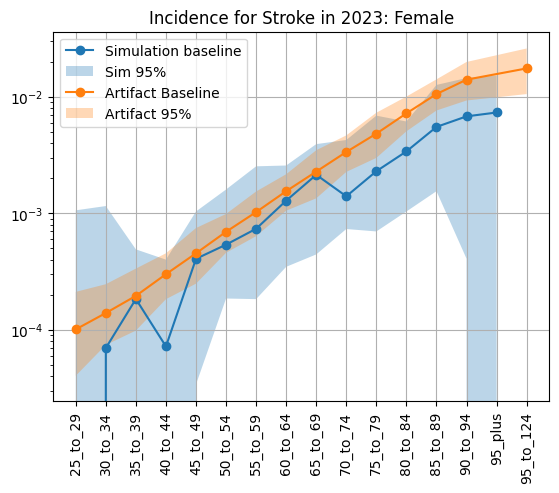

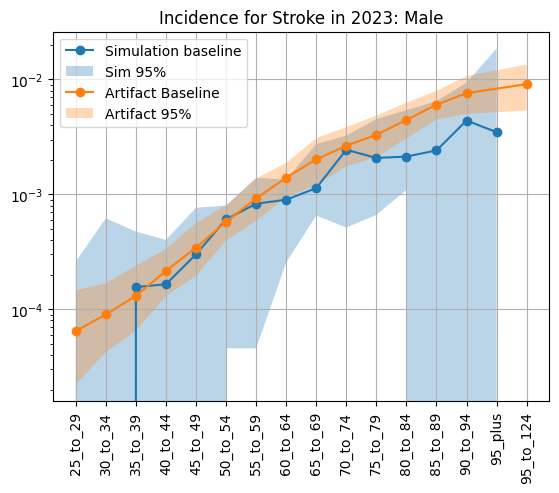

In [54]:
for sex in tran_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex) & (tran_rate_sum_allyear.year==2023)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_inc.loc[(art_inc.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Incidence for Stroke in 2023: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

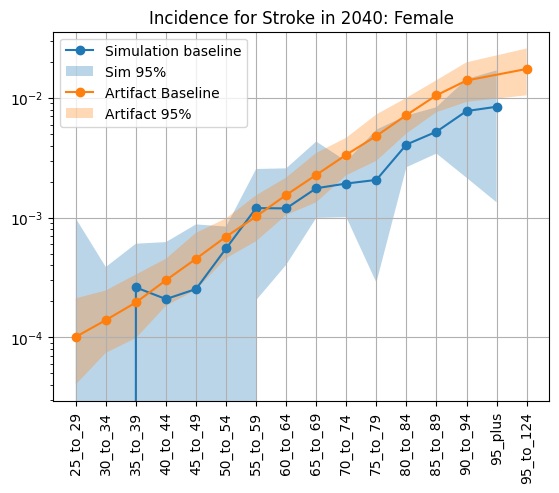

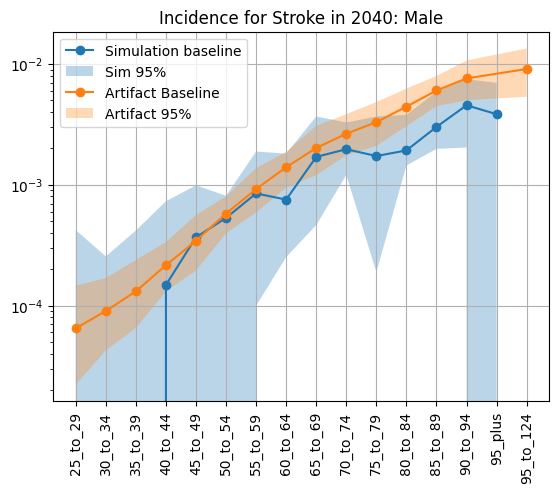

In [55]:
for sex in tran_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex) & (tran_rate_sum_allyear.year==2040)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_inc.loc[(art_inc.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Incidence for Stroke in 2040: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for MI

In [56]:
art_inc_acute_MI = load_artifact_data('cause', 'acute_myocardial_infarction', 'incidence_rate')
art_inc_acute_MI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_acute_MI.age_start,art_inc_acute_MI.age_end)]
art_inc_acute_MI.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000403,0.000254,0.000570,Washington,incidence_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000444,0.000295,0.000605,Washington,incidence_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000346,0.000240,0.000478,Washington,incidence_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000410,0.000307,0.000538,Washington,incidence_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.000637,0.000480,0.000820,Washington,incidence_rate,45_to_49


In [57]:
groupby_cols2 = ['age', 'sex', 'input_draw']
tran_rate_MI_HF = tran_rate_MI_HF.groupby(groupby_cols2).sum() / per_time_sus_MI.groupby(groupby_cols2).sum()
tran_rate_MI_HF = (tran_rate_MI_HF.groupby([c for c in groupby_cols2 if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.5, 0.975])
                   .filter(['mean','50%', '2.5%', '97.5%']))
                 
tran_rate_MI_HF.head()

mean  50%  2.5%  97.5%
age      sex                           
25_to_29 Female   0.0  0.0   0.0    0.0
         Male     0.0  0.0   0.0    0.0
30_to_34 Female   0.0  0.0   0.0    0.0
         Male     0.0  0.0   0.0    0.0
35_to_39 Female   0.0  0.0   0.0    0.0

In [58]:
groupby_cols2 = ['age', 'sex', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols2).sum() / per_time_sus_MI.groupby(groupby_cols2).sum()
tran_MI_summ_allyear = (tran_rate_MI_all.groupby([c for c in groupby_cols2 if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.5, 0.975])
                   .filter(['mean','50%', '2.5%', '97.5%']))
                 
tran_MI_summ_allyear.head()

mean       50%      2.5%     97.5%
age      sex                                           
25_to_29 Female  0.001067  0.000377  0.000070  0.003558
         Male    0.000728  0.000377  0.000035  0.002191
30_to_34 Female  0.000666  0.000348  0.000059  0.002039
         Male    0.001052  0.000436  0.000130  0.003794
35_to_39 Female  0.000456  0.000391  0.000231  0.000812

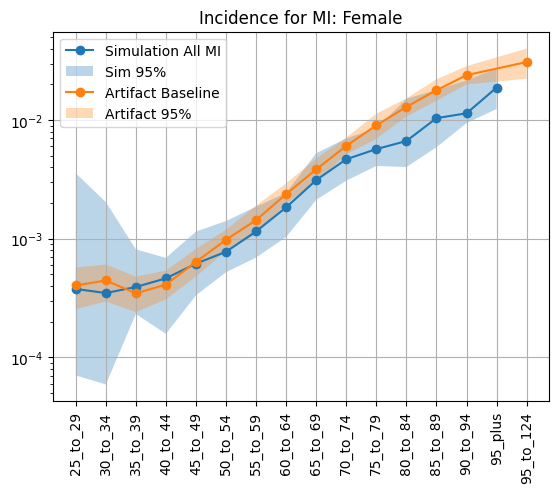

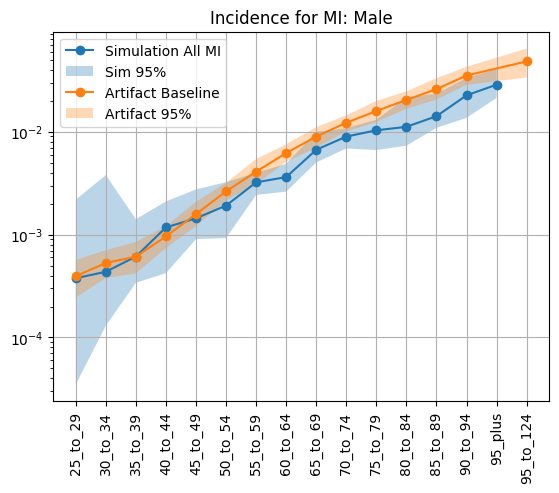

In [59]:
for sex in tran_MI_summ_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_MI_summ_allyear.loc[(tran_MI_summ_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['50%'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_acute_MI.loc[(art_inc_acute_MI.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Incidence Rates for Heart Failure IHD

In [60]:
art_inc_HF_IHD = load_artifact_data('cause', 'heart_failure_from_ischemic_heart_disease', 'incidence_rate')
art_inc_HF_IHD['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_HF_IHD.age_start,art_inc_HF_IHD.age_end)]
art_inc_HF_IHD.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000038,0.000027,0.000051,Washington,incidence_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000051,0.000037,0.000066,Washington,incidence_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000045,0.000029,0.000066,Washington,incidence_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000072,0.000054,0.000097,Washington,incidence_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.000220,0.000178,0.000266,Washington,incidence_rate,45_to_49


In [63]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['susceptible_to_ischemic_heart_disease_and_heart_failure','post_myocardial_infarction','acute_myocardial_infarction_and_heart_failure']))].reset_index()
tran_rate_HF_IHD = tran.loc[(tran['transition'].isin(['acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease']))].reset_index()
groupby_cols = ['age', 'sex', 'input_draw']
tran_rate_HF_IHD = tran_rate_HF_IHD.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_IHD_allyear = (tran_rate_HF_IHD.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_IHD_allyear.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 Female  0.000046  0.000026  0.000069
         Male    0.000076  0.000022  0.000148
30_to_34 Female  0.000039  0.000000  0.000087
         Male    0.000130  0.000091  0.000165
35_to_39 Female  0.000043  0.000018  0.000072

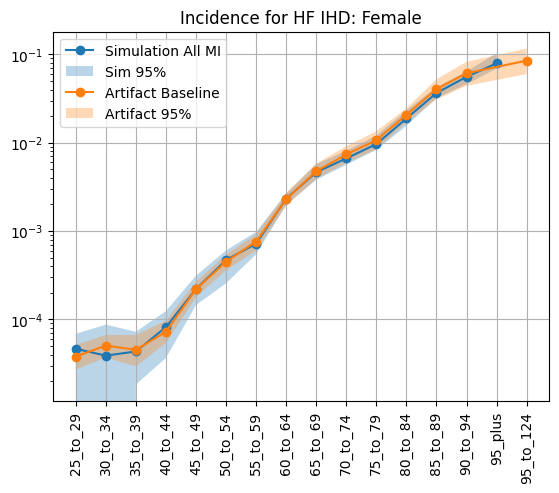

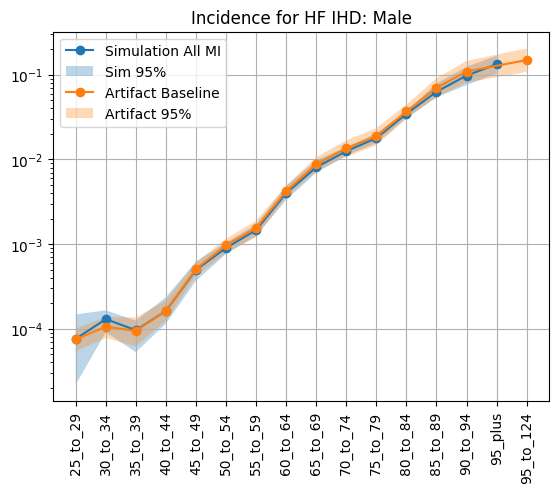

In [64]:
for sex in tran_rate_HF_IHD_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_rate_HF_IHD_allyear.loc[(tran_rate_HF_IHD_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_HF_IHD.loc[(art_inc_HF_IHD.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for HF IHD: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Incidence Rates for Heart Failure Residual

In [65]:
art_inc_HF_resid = load_artifact_data('cause', 'heart_failure_residual', 'incidence_rate')
art_inc_HF_resid['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_HF_resid.age_start,art_inc_HF_resid.age_end)]
art_inc_HF_resid.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000467,0.000332,0.000631,Washington,incidence_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.000422,0.000309,0.000555,Washington,incidence_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.000255,0.000166,0.000374,Washington,incidence_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.000410,0.000306,0.000548,Washington,incidence_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.000800,0.000647,0.000965,Washington,incidence_rate,45_to_49


In [66]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['susceptible_to_ischemic_heart_disease_and_heart_failure']))].reset_index()
tran_rate_HF_resid = tran.loc[(tran['transition'].isin(['susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
groupby_cols = ['age', 'sex', 'input_draw']
tran_rate_HF_resid = tran_rate_HF_resid.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_resid_allyear = (tran_rate_HF_resid.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_resid_allyear.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 Female  0.000485  0.000333  0.000605
         Male    0.000687  0.000512  0.000891
30_to_34 Female  0.000448  0.000357  0.000574
         Male    0.000593  0.000447  0.000790
35_to_39 Female  0.000284  0.000170  0.000373

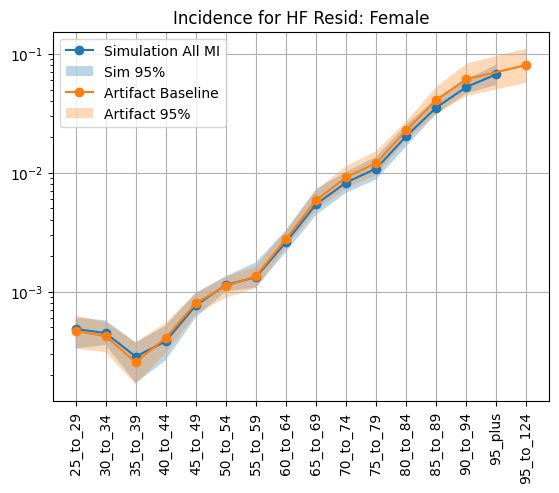

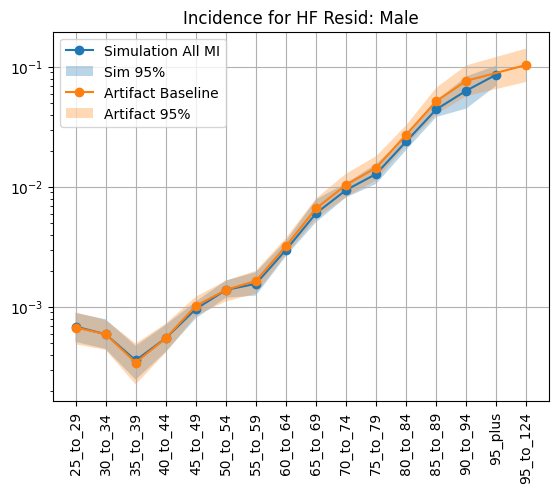

In [67]:
for sex in tran_rate_HF_resid_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_rate_HF_resid_allyear.loc[(tran_rate_HF_resid_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_HF_resid.loc[(art_inc_HF_resid.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for HF Resid: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Matches the artifact but the artifact looks weird for the youngest folks 

#### Prevalence Rates

In [68]:
prev_chronic_rate_sum_allyear = (prev_chronic_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [69]:
art_prev = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'prevalence')
art_prev['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev.age_start,art_prev.age_end)]
art_prev.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.003489,0.002555,0.004454,Washington,prevalence,25_to_29
1,Female,30.0,35.0,2019,2020,0.004250,0.003222,0.005403,Washington,prevalence,30_to_34
2,Female,35.0,40.0,2019,2020,0.005317,0.004100,0.006776,Washington,prevalence,35_to_39
3,Female,40.0,45.0,2019,2020,0.006845,0.005258,0.008808,Washington,prevalence,40_to_44
4,Female,45.0,50.0,2019,2020,0.009282,0.007235,0.011875,Washington,prevalence,45_to_49


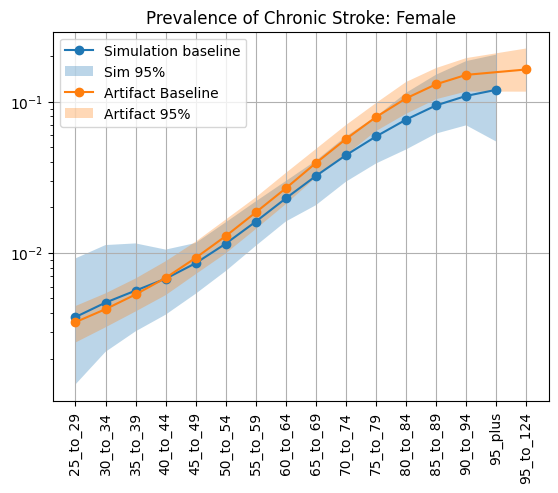

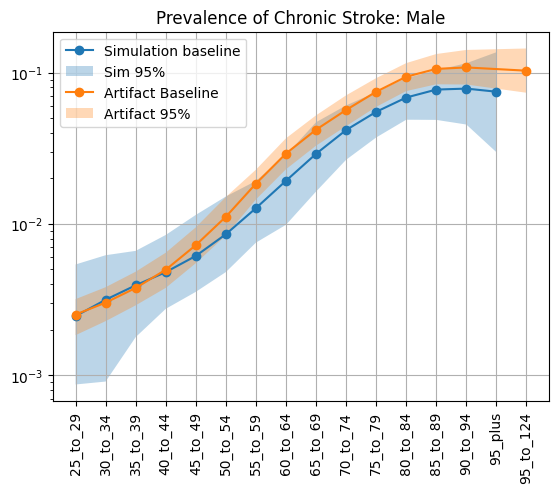

In [70]:
for sex in prev_chronic_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_chronic_rate_sum_allyear.loc[(prev_chronic_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev.loc[(art_prev.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [71]:
prev_acute_rate_sum_allyear = (prev_acute_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [72]:
art_prev2 = load_artifact_data('sequela', 'acute_ischemic_stroke', 'prevalence')
art_prev2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev2.age_start,art_prev2.age_end)]

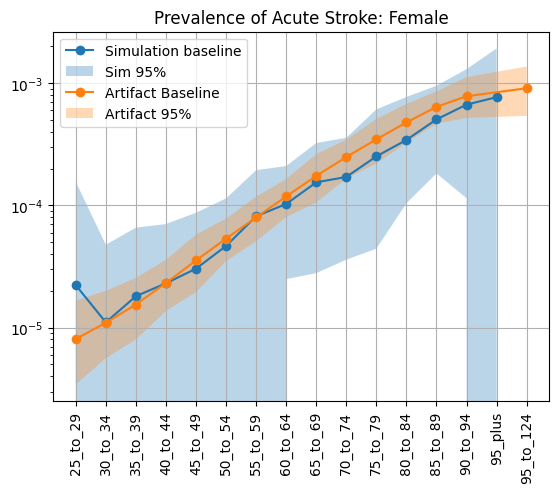

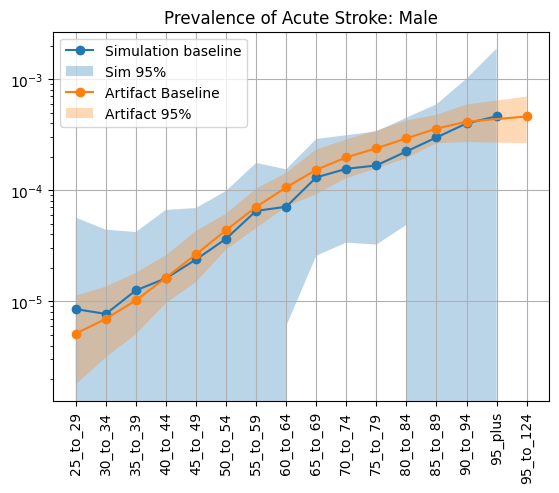

In [73]:
for sex in prev_acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_rate_sum_allyear.loc[(prev_acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev2.loc[(art_prev2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Prevalence of Post MI

In [74]:
art_prev3 = load_artifact_data('cause', 'post_myocardial_infarction', 'prevalence')
art_prev3['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev3.age_start,art_prev3.age_end)]
art_prev3.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.001021,0.000776,0.001289,Washington,prevalence,25_to_29
1,Female,30.0,35.0,2019,2020,0.002129,0.001572,0.002708,Washington,prevalence,30_to_34
2,Female,35.0,40.0,2019,2020,0.003355,0.002647,0.004104,Washington,prevalence,35_to_39
3,Female,40.0,45.0,2019,2020,0.004687,0.003764,0.005751,Washington,prevalence,40_to_44
4,Female,45.0,50.0,2019,2020,0.006370,0.005147,0.007663,Washington,prevalence,45_to_49


In [75]:
prev_post_MI_sum_allyear = (prev_post_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_sum_allyear.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.002748,0.000749,0.009201
1,25_to_29,Female,2024,0.003187,0.000853,0.011306
2,25_to_29,Female,2025,0.003617,0.000509,0.012966
3,25_to_29,Female,2026,0.003883,0.000412,0.014347
4,25_to_29,Female,2027,0.004005,0.000418,0.014779


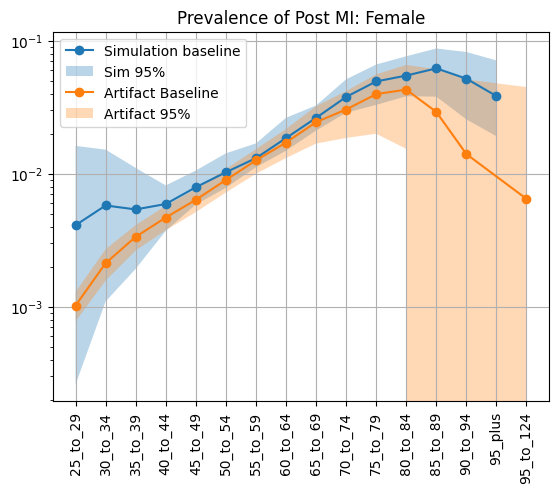

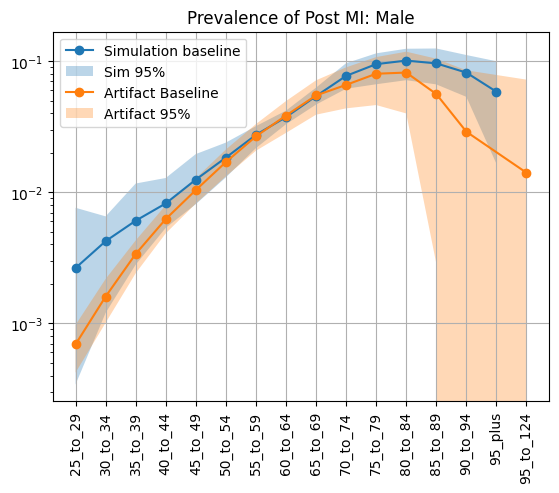

In [76]:
##Can try plotting the median 

for sex in prev_post_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_post_MI_sum_allyear.loc[(prev_post_MI_sum_allyear.sex==sex) & (prev_post_MI_sum_allyear.year == 2029)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev3.loc[(art_prev3.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [ ]:
## 2023 looks pretty good but 2040 looks pretty bad 

#### Prevalence of Acute MI

In [77]:
art_prev4 = load_artifact_data('cause', 'acute_myocardial_infarction', 'prevalence')
art_prev4['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev4.age_start,art_prev4.age_end)]
art_prev4.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000027,0.000017,0.000038,Washington,prevalence,25_to_29
1,Female,30.0,35.0,2019,2020,0.000033,0.000022,0.000046,Washington,prevalence,30_to_34
2,Female,35.0,40.0,2019,2020,0.000026,0.000019,0.000036,Washington,prevalence,35_to_39
3,Female,40.0,45.0,2019,2020,0.000029,0.000021,0.000040,Washington,prevalence,40_to_44
4,Female,45.0,50.0,2019,2020,0.000045,0.000034,0.000058,Washington,prevalence,45_to_49


In [78]:
prev_acute_MI_sum_allyear = (prev_acute_MI
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.000081,0.0,0.000351
1,25_to_29,Male,0.000056,0.0,0.000223
2,30_to_34,Female,0.000051,0.0,0.000199
3,30_to_34,Male,0.000081,0.0,0.000377
4,35_to_39,Female,0.000035,0.0,0.000087


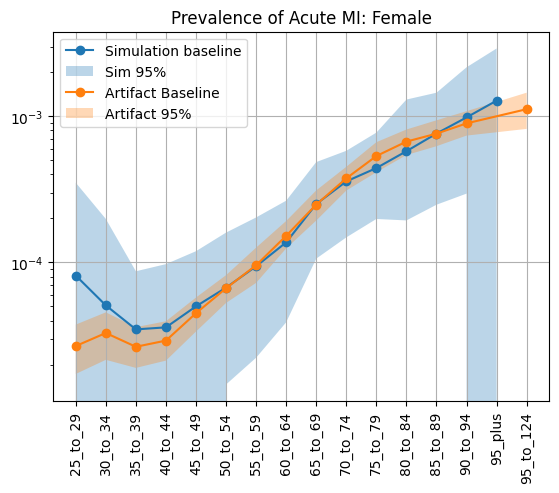

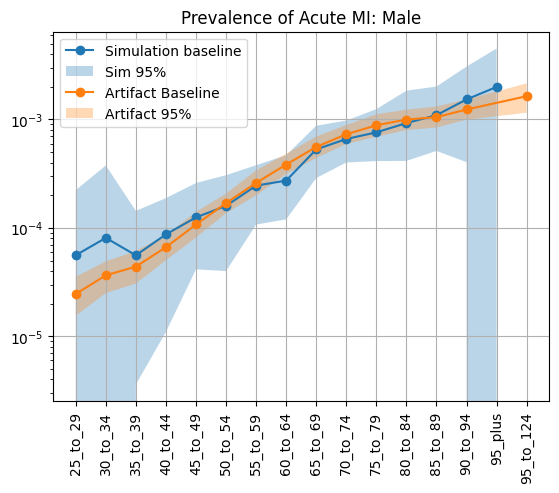

In [79]:
for sex in prev_acute_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_MI_sum_allyear.loc[(prev_acute_MI_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev4.loc[(art_prev4.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Prevalence of Heart Failure IHD

In [80]:
art_prev_hf_ihd = load_artifact_data('cause', 'heart_failure_from_ischemic_heart_disease', 'prevalence')
art_prev_hf_ihd['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev_hf_ihd.age_start,art_prev_hf_ihd.age_end)]
art_prev_hf_ihd.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.000163,0.000121,0.000214,Washington,prevalence,25_to_29
1,Female,30.0,35.0,2019,2020,0.000332,0.000241,0.000441,Washington,prevalence,30_to_34
2,Female,35.0,40.0,2019,2020,0.000426,0.000326,0.000545,Washington,prevalence,35_to_39
3,Female,40.0,45.0,2019,2020,0.000344,0.000277,0.000431,Washington,prevalence,40_to_44
4,Female,45.0,50.0,2019,2020,0.000720,0.000613,0.000843,Washington,prevalence,45_to_49


In [81]:
prev_HF_IHD = per_time_state.loc[(per_time_state['state'] == 'heart_failure_from_ischemic_heart_disease')].reset_index()
prev_HF_IHD = prev_HF_IHD.rename(columns = {'ptvalue':'value'})
prev_HF_IHD = prev_HF_IHD.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF_IHD['rate']= prev_HF_IHD['value'] / prev_HF_IHD['ptvalue']
prev_HF_IHD_allyear = (prev_HF_IHD
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_IHD_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.000159,0.000000,0.000483
1,25_to_29,Male,0.000244,0.000000,0.000610
2,30_to_34,Female,0.000210,0.000000,0.000643
3,30_to_34,Male,0.000452,0.000035,0.001166
4,35_to_39,Female,0.000256,0.000000,0.000772


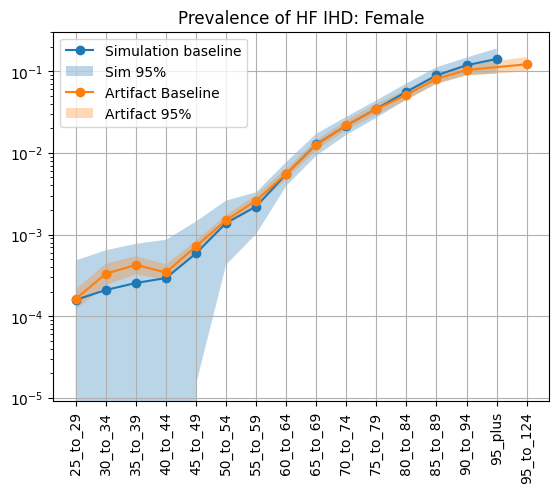

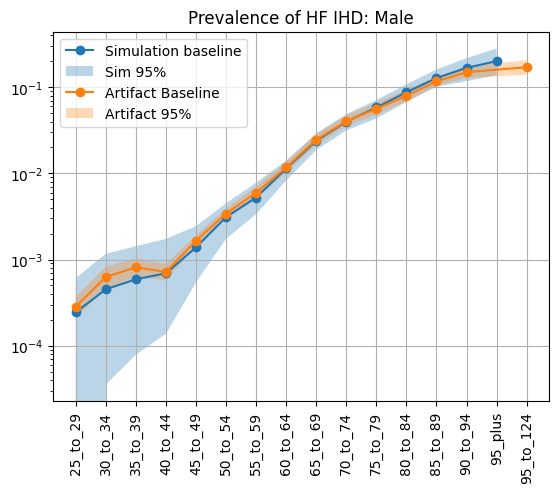

In [82]:
for sex in prev_HF_IHD_allyear.sex.unique():
    plt.figure() 
    subdata = prev_HF_IHD_allyear.loc[(prev_HF_IHD_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev_hf_ihd.loc[(art_prev_hf_ihd.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of HF IHD: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Prevalence of Heart Failure Residual

In [83]:
art_prev_hf_resid = load_artifact_data('cause', 'heart_failure_residual', 'prevalence')
art_prev_hf_resid['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev_hf_resid.age_start,art_prev_hf_resid.age_end)]
art_prev_hf_resid.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.002004,0.001480,0.002625,Washington,prevalence,25_to_29
1,Female,30.0,35.0,2019,2020,0.002767,0.002009,0.003677,Washington,prevalence,30_to_34
2,Female,35.0,40.0,2019,2020,0.002397,0.001832,0.003066,Washington,prevalence,35_to_39
3,Female,40.0,45.0,2019,2020,0.001935,0.001560,0.002428,Washington,prevalence,40_to_44
4,Female,45.0,50.0,2019,2020,0.002598,0.002211,0.003041,Washington,prevalence,45_to_49


In [84]:
prev_HF_resid = per_time_state.loc[(per_time_state['state'] == 'heart_failure_residual')].reset_index()
prev_HF_resid = prev_HF_resid.rename(columns = {'ptvalue':'value'})
prev_HF_resid = prev_HF_resid.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF_resid['rate']= prev_HF_resid['value'] / prev_HF_resid['ptvalue']
prev_HF_resid_allyear = (prev_HF_resid
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_resid_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.002226,0.000738,0.003737
1,25_to_29,Male,0.002690,0.001318,0.004079
2,30_to_34,Female,0.002786,0.001331,0.004346
3,30_to_34,Male,0.003447,0.002006,0.005250
4,35_to_39,Female,0.002595,0.001361,0.004034


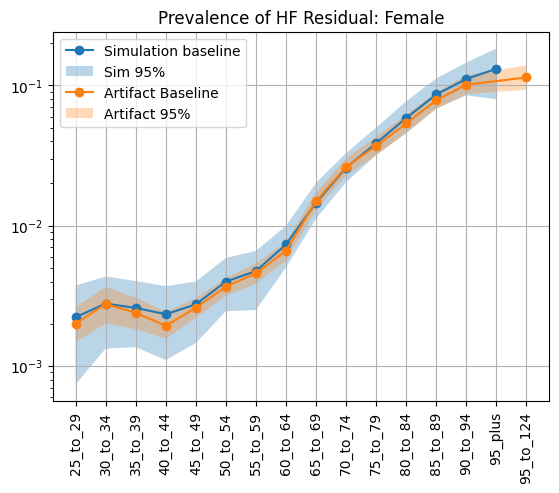

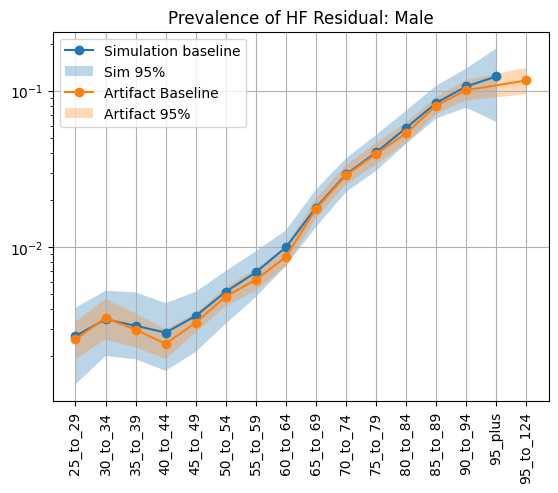

In [85]:
for sex in prev_HF_resid_allyear.sex.unique():
    plt.figure() 
    subdata = prev_HF_resid_allyear.loc[(prev_HF_resid_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev_hf_resid.loc[(art_prev_hf_resid.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of HF Residual: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Excess Mortality Rate

#### Acute Stroke

In [86]:
art_emr = load_artifact_data('sequela', 'acute_ischemic_stroke', 'excess_mortality_rate')
art_emr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr.age_start,art_emr.age_end)]
art_emr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.225045,0.154097,0.319167,Washington,excess_mortality_rate,25_to_29
1,Female,30.0,35.0,2019,2020,0.206130,0.142209,0.290406,Washington,excess_mortality_rate,30_to_34
2,Female,35.0,40.0,2019,2020,0.226292,0.160748,0.307784,Washington,excess_mortality_rate,35_to_39
3,Female,40.0,45.0,2019,2020,0.227183,0.164469,0.309381,Washington,excess_mortality_rate,40_to_44
4,Female,45.0,50.0,2019,2020,0.208802,0.144385,0.291302,Washington,excess_mortality_rate,45_to_49


In [88]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'acute_ischemic_stroke')].reset_index()
acute_rate_emr = pd.concat([acute_rate, prev_acute.ptvalue], axis=1)
acute_rate_emr['mean_rate'] = acute_rate_emr['value'] / acute_rate_emr['ptvalue']

acute_rate_sum_allyear = (acute_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.562048,0.0,7.989844
1,25_to_29,Male,0.751055,0.0,10.761830
2,30_to_34,Female,0.347857,0.0,1.956696
3,30_to_34,Male,0.517645,0.0,9.457366
4,35_to_39,Female,0.163058,0.0,0.000000


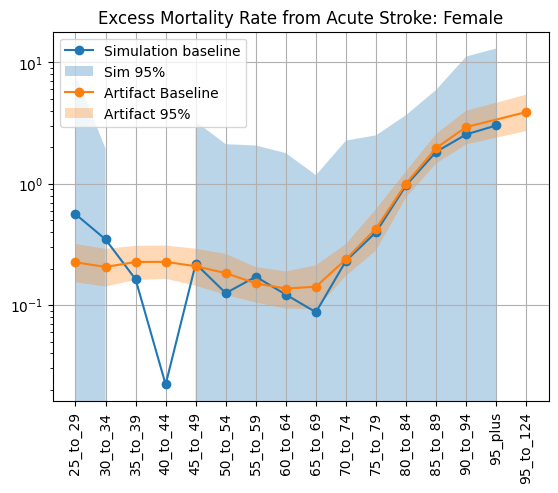

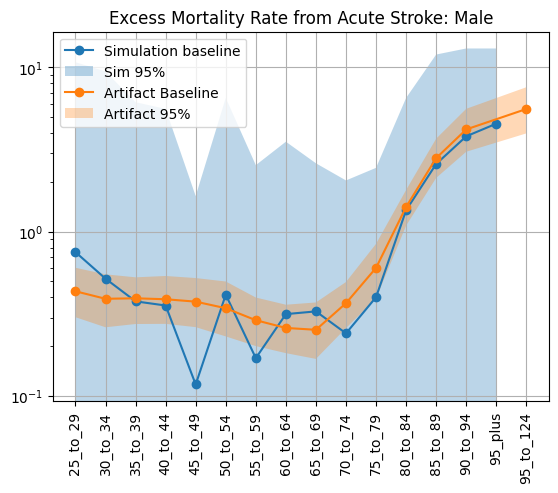

In [89]:
for sex in acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = acute_rate_sum_allyear.loc[(acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr.loc[(art_emr.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Chronic Stroke

In [90]:
art_emr2 = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'excess_mortality_rate')
art_emr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr2.age_start,art_emr2.age_end)]

In [91]:
chronic = per_time_state.loc[(per_time_state['state'] == 'chronic_ischemic_stroke')].reset_index()
#chronic = chronic.rename(columns = {'value':'ptvalue'})
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate_emr = pd.concat([chronic_rate, chronic.ptvalue], axis=1)
chronic_rate_emr['mean_rate'] = chronic_rate_emr['value'] / chronic_rate_emr['ptvalue']
chronic_rate_emr_allyear = (chronic_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


chronic_rate_emr_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.000000,0.0,0.0
1,25_to_29,Male,0.000000,0.0,0.0
2,30_to_34,Female,0.000211,0.0,0.0
3,30_to_34,Male,0.000000,0.0,0.0
4,35_to_39,Female,0.000000,0.0,0.0


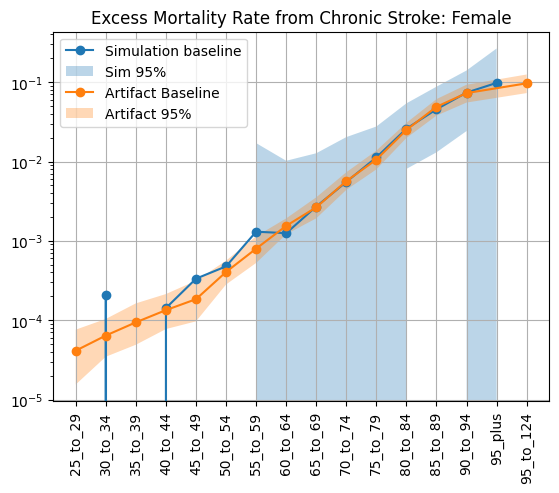

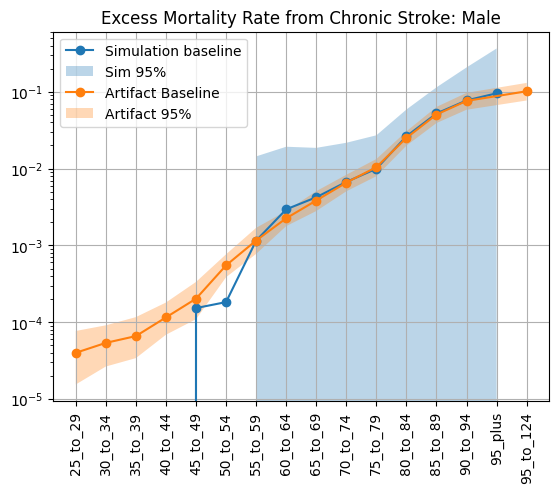

In [92]:
for sex in chronic_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = chronic_rate_emr_allyear.loc[(chronic_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr2.loc[(art_emr2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Acute MI

In [93]:
art_emr_acuteMI = load_artifact_data('cause', 'acute_myocardial_infarction', 'excess_mortality_rate')
art_emr_acuteMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_acuteMI.age_start,art_emr_acuteMI.age_end)]

In [94]:
acute_MI_EMR = per_time_state.loc[(per_time_state['state'] == 'acute_myocardial_infarction_and_heart_failure') | ((per_time_state['state'] == 'acute_myocardial_infarction'))].reset_index()
acute_MI_EMR = acute_MI_EMR.groupby(['age','year','sex','input_draw']).ptvalue.sum().reset_index()
acute_MI_emr_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure') | (death_rate_cause['cause'] == 'acute_myocardial_infarction')].reset_index()
acute_MI_emr_rate = acute_MI_emr_rate.groupby(['age','year','sex','input_draw']).value.sum().reset_index()
acute_MI_emr_rate = acute_MI_emr_rate.merge(acute_MI_EMR[['age','year','sex','input_draw','ptvalue']], on=['age','year','sex','input_draw'])
acute_MI_emr_rate['mean_rate'] = acute_MI_emr_rate['value'] / acute_MI_emr_rate['ptvalue']
acute_MI_emr_rate_allyear = (acute_MI_emr_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
acute_MI_emr_rate_allyear.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,2.138632,0.0,7.826786
1,25_to_29,Female,2024,1.482766,0.0,4.043839
2,25_to_29,Female,2025,1.433552,0.0,5.951618
3,25_to_29,Female,2026,2.279518,0.0,6.033147
4,25_to_29,Female,2027,1.355797,0.0,4.043839


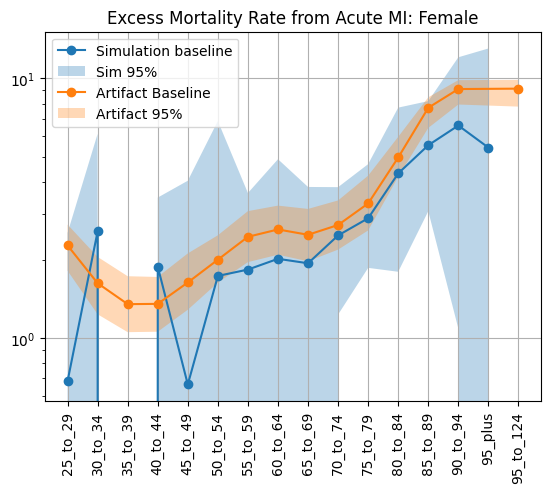

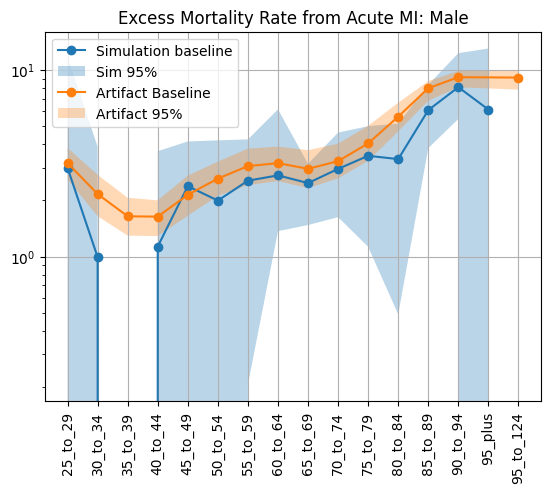

In [95]:
for sex in acute_MI_emr_rate_allyear.sex.unique():
    plt.figure() 
    subdata = acute_MI_emr_rate_allyear.loc[(acute_MI_emr_rate_allyear.sex==sex) & (acute_MI_emr_rate_allyear.year==2029)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_acuteMI.loc[(art_emr_acuteMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Post MI EMR

In [96]:
post_mi_rate_emr_allyear = (post_MI_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


post_mi_rate_emr_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,Female,0.038395,0.0,0.160895
1,25_to_29,Male,0.051105,0.0,0.285719
2,30_to_34,Female,0.025138,0.0,0.179462
3,30_to_34,Male,0.018004,0.0,0.109179
4,35_to_39,Female,0.012068,0.0,0.069986


In [97]:
art_emr_postMI = load_artifact_data('cause', 'post_myocardial_infarction', 'excess_mortality_rate')
art_emr_postMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_postMI.age_start,art_emr_postMI.age_end)]

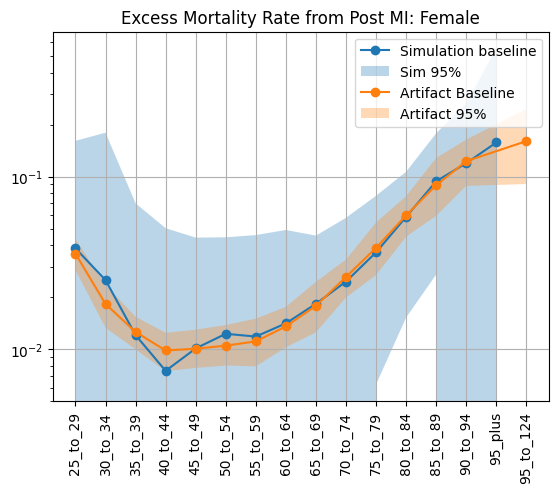

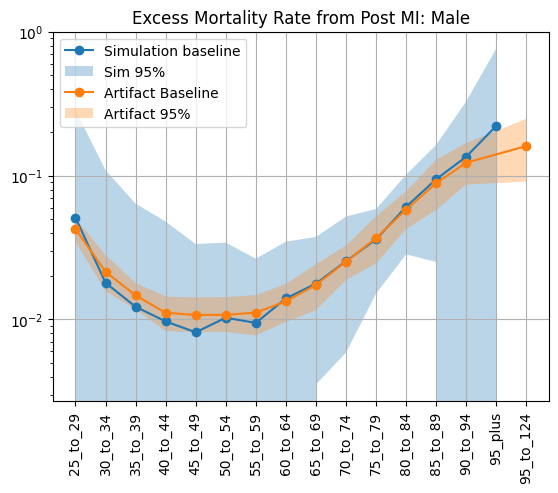

In [98]:
for sex in post_mi_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = post_mi_rate_emr_allyear.loc[(post_mi_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_postMI.loc[(art_emr_postMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 